In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import ndimage
import glob
import cv2
import pickle
import patchify
import matplotlib.cm as cm
from scipy.optimize import minimize

plt.rcParams['figure.dpi'] = 200

In [2]:
fn_img = glob.glob("ML/output*/")
fn_img.sort()
imgall=[]


for fn in fn_img:
    #import image with depth
    image = np.load(fn+'stats.npy')
    imageD=image.reshape(1242, 2208, 5)[:,:,0]
    imageD-=np.min(imageD)
    imageD/=np.max(imageD)
    imageD=imageD*255
    image = cv2.imread(fn+'imgL.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.dstack([image,imageD])
    image=image.astype('uint8')
    imgall.append(image)

In [13]:
model = tf.keras.models.load_model(
    "tabletennisunet64-px128-bs64-lr0.010-ep100.hdf5", compile=False
)

In [12]:
pty_image=[]

for img in imgall:
    pty_img = patchify.patchify(img, (128,128,4),step=118)
    pty_image.append(pty_img.reshape(pty_img.shape[0]*pty_img.shape[1],128,128,4))

In [22]:
y_predall=[]
for x in pty_image[:5]:
    y_pred = model.predict(x)
    y_predall.append(y_pred)

1/1 [==============================] - 16s 16s/step


In [35]:
desired_shape = (2304, 2304, 4)
imgallSQ=[]
for img in imgall:
    # Create a new array with the desired shape, filled with zeros
    new_rgb_depth_image = np.zeros(desired_shape, dtype=img.dtype)

    # Copy the original image into the new array
    new_rgb_depth_image[0:img.shape[0], 
                        0:img.shape[1], :] = img

    new_rgb_depth_image=np.expand_dims(new_rgb_depth_image,axis=0)
    imgallSQ.append(new_rgb_depth_image)

In [42]:
y_predall=[]
for x in imgallSQ:
    y_pred = model.predict(x)
    y_predall.append(y_pred)


1/1 [==============================] - 29s 29s/step


In [45]:
for fn,y in zip(fn_img,y_predall):
    with open(fn+'unet_mask.pickle', 'wb') as handle:
        pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
for fn,y in zip(fn_img,y_predall):
    np.save(fn+'unet_mask.npy',y)

In [3]:
y_predall=[]
for fn in fn_img:
    #import image with depth
    y = np.load(fn+'unet_mask.npy')
    y_predall.append(y[0,:1242,:2208])

In [4]:
mask=y_predall[0][:,:,0]>0.95
# Use connected component analysis to label distinct regions in the mask
labeled_mask, num_labels = ndimage.label(mask)

In [5]:
np.unique(labeled_mask)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

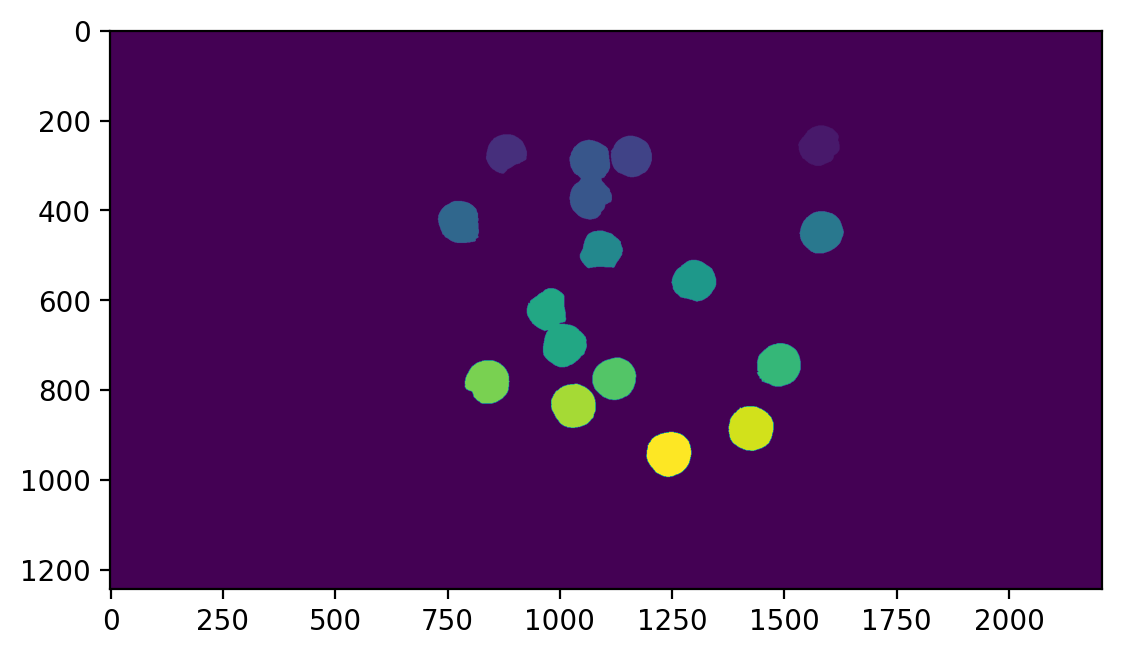

In [6]:
plt.imshow(labeled_mask)

In [7]:
# Create an array to store each subject separately
subjects = []
# Iterate through each labeled region and extract it into a separate array
for label in range(1, num_labels + 1):
    subject_mask = (labeled_mask == label)
    subject = np.zeros_like(mask)
    subject[subject_mask] = mask[subject_mask]
    subjects.append(subject[:, :, np.newaxis])#for masking to match dimension


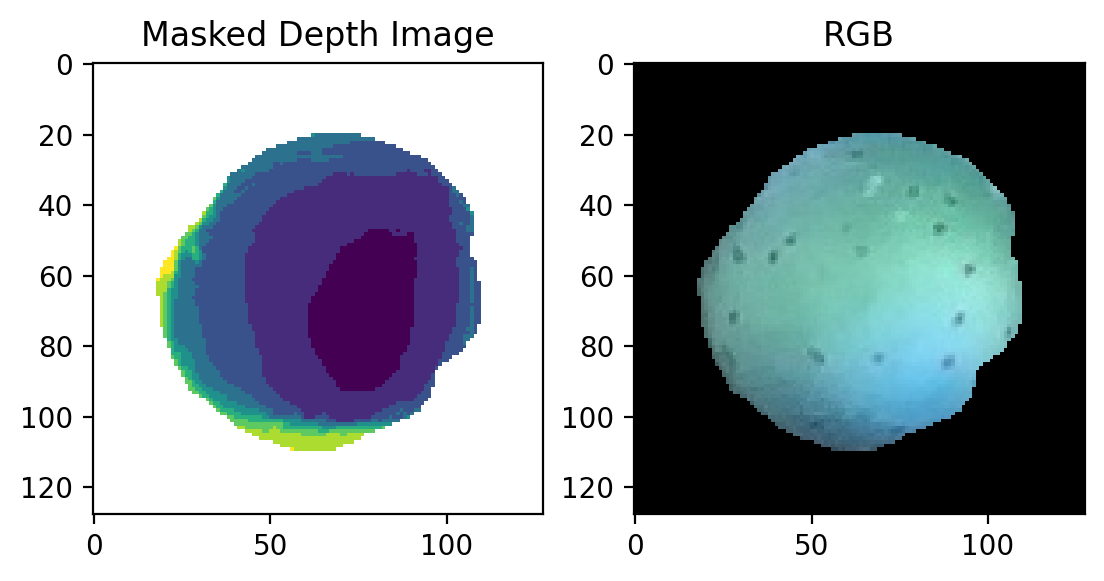

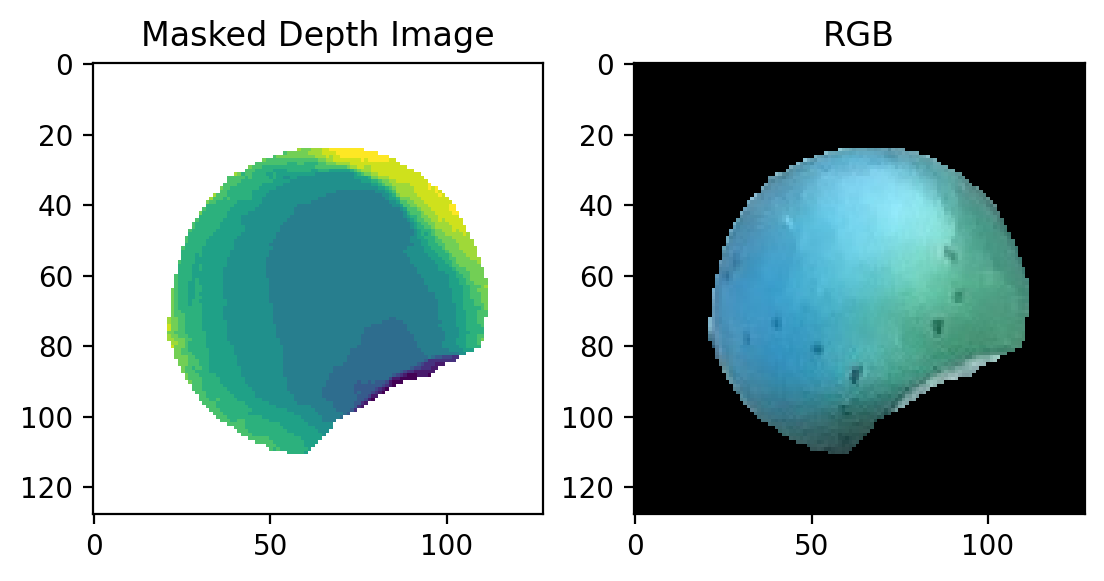

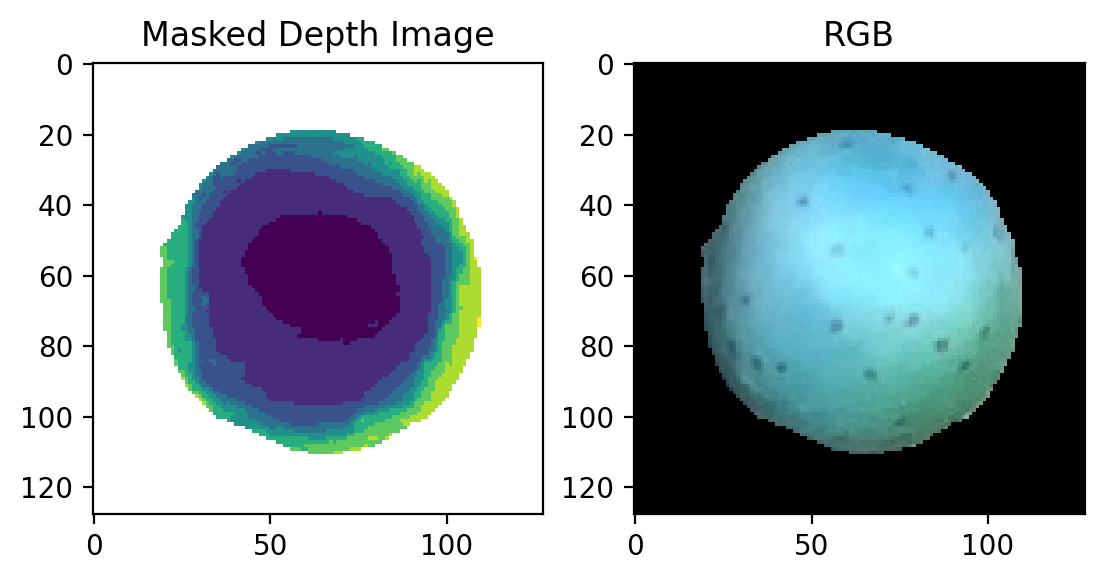

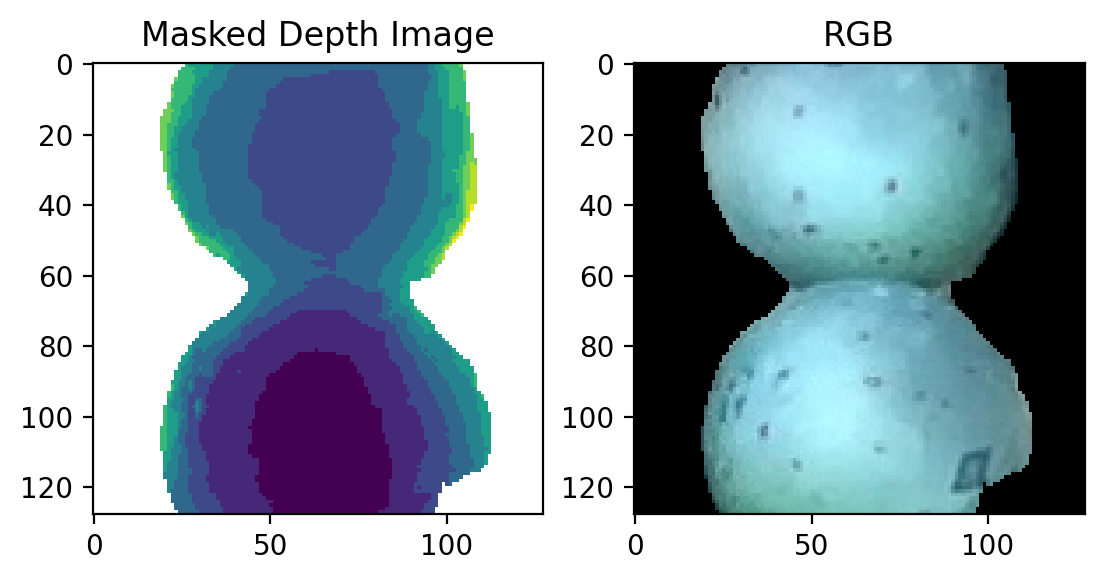

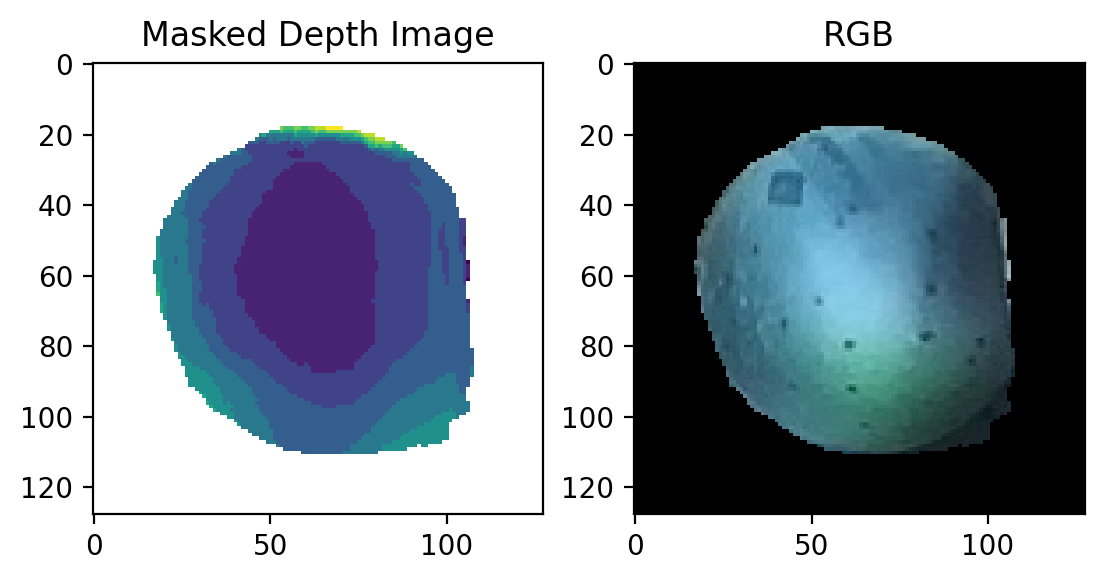

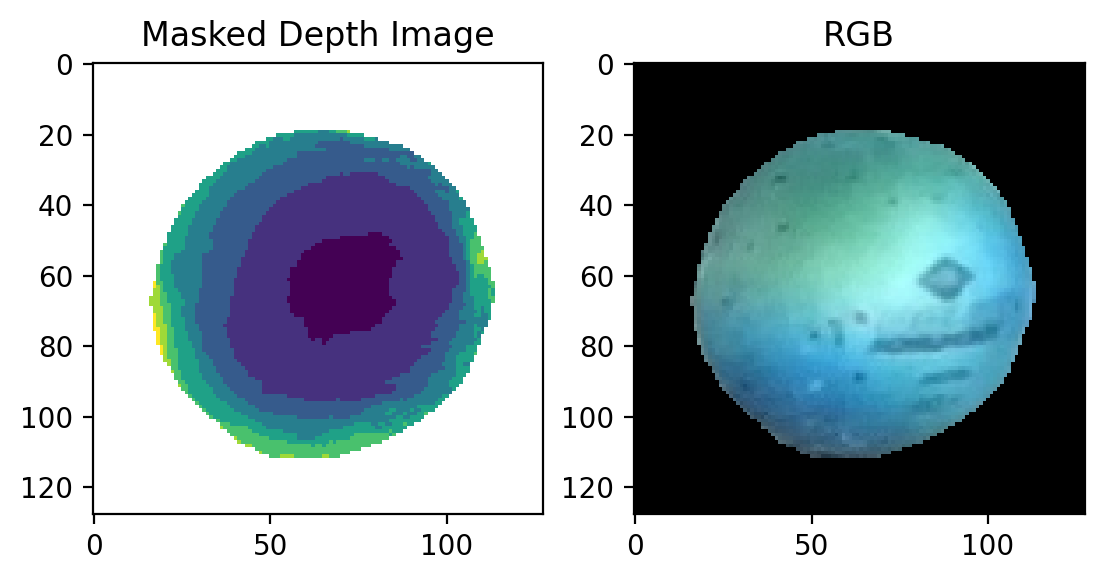

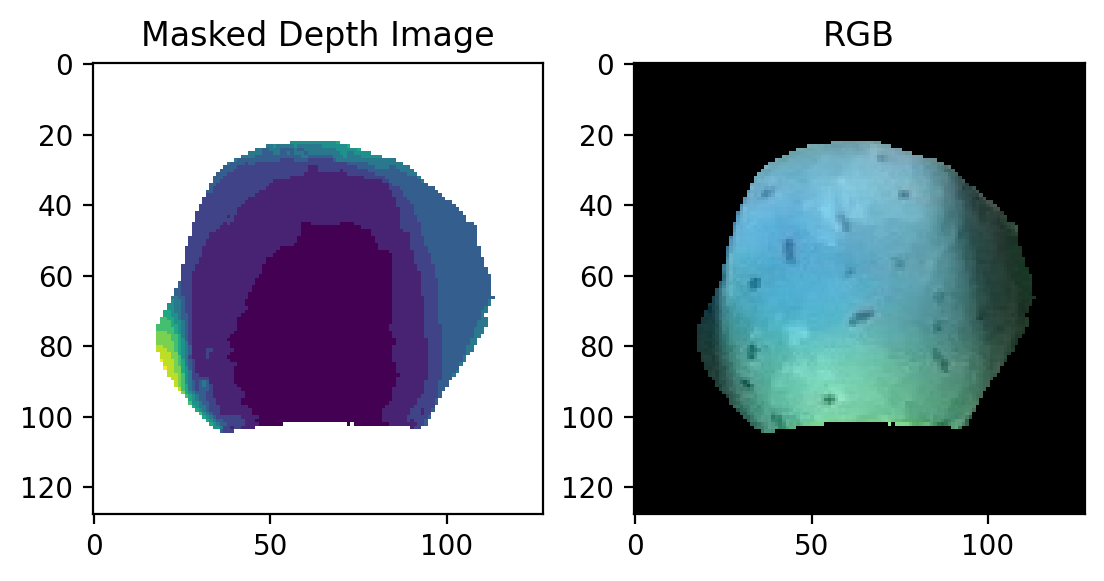

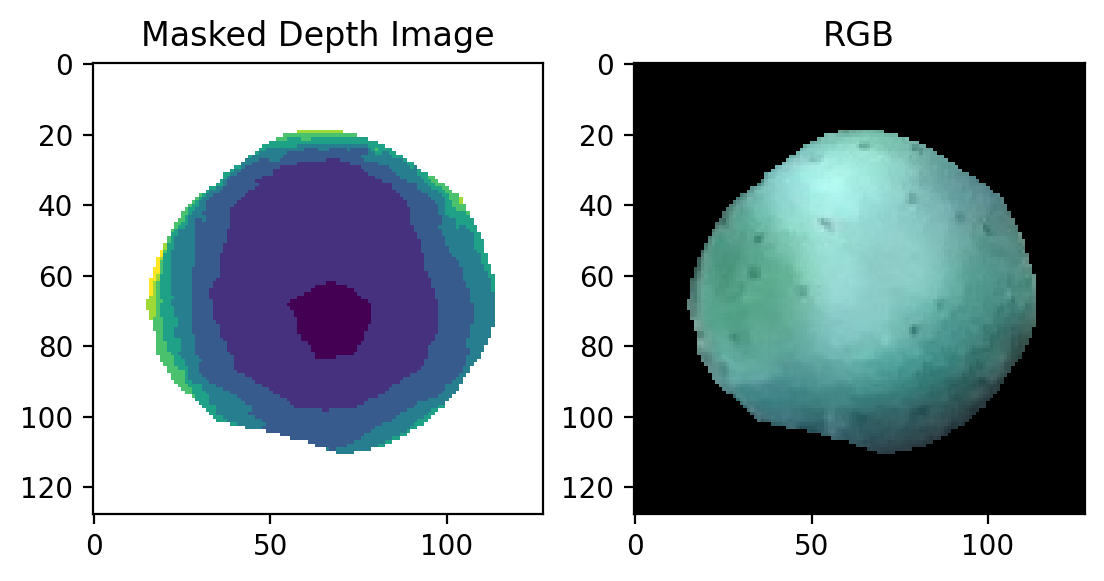

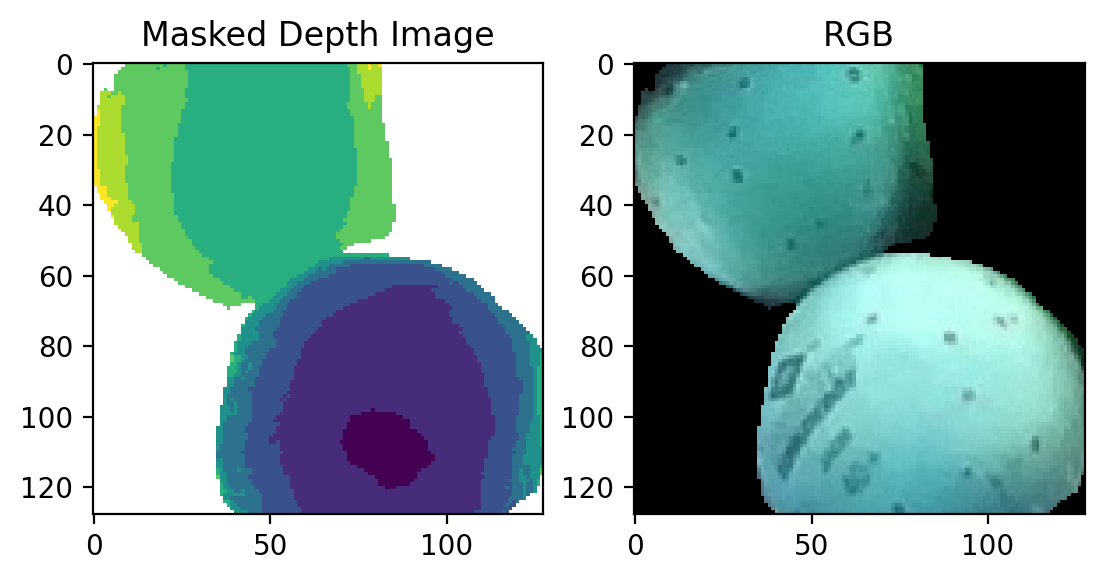

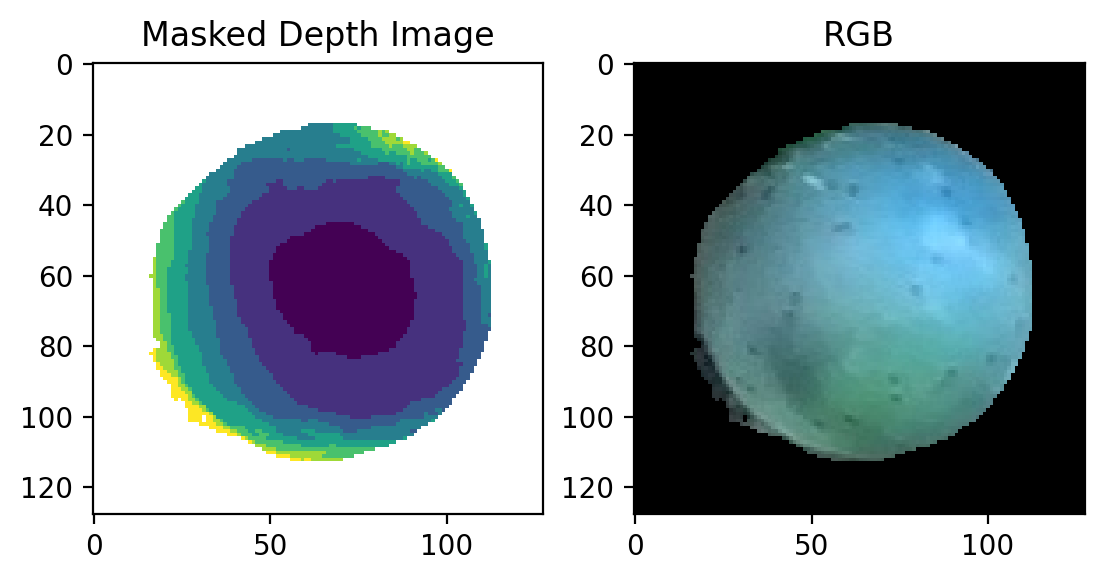

In [26]:
for i in range(10):
    #i=0
    p=0
    masked_image = np.where(subjects[i], imgall[p], np.nan)
    notnan_indices = np.where(~np.isnan(masked_image))

    test=imgall[p]*np.tile(subjects[i], (1, 1, 4))

    x = np.mean(notnan_indices[0]).astype(int)
    y = np.mean(notnan_indices[1]).astype(int)
    clip_masked_image=masked_image[x-64:x+64, y-64:y+64,3]

    # Plot the masked depth image
    img, (ax1,ax2)=plt.subplots(1,2)
    #ax1.imshow(test[x-64:x+64, y-64:y+64,3], cmap='viridis')
    ax1.imshow(clip_masked_image, cmap='viridis')

    ax2.imshow(test[x-64:x+64, y-64:y+64,:3])
    #plt.colorbar()  # Add a colorbar for reference
    ax1.set_title('Masked Depth Image')
    ax2.set_title('RGB')
    plt.show()

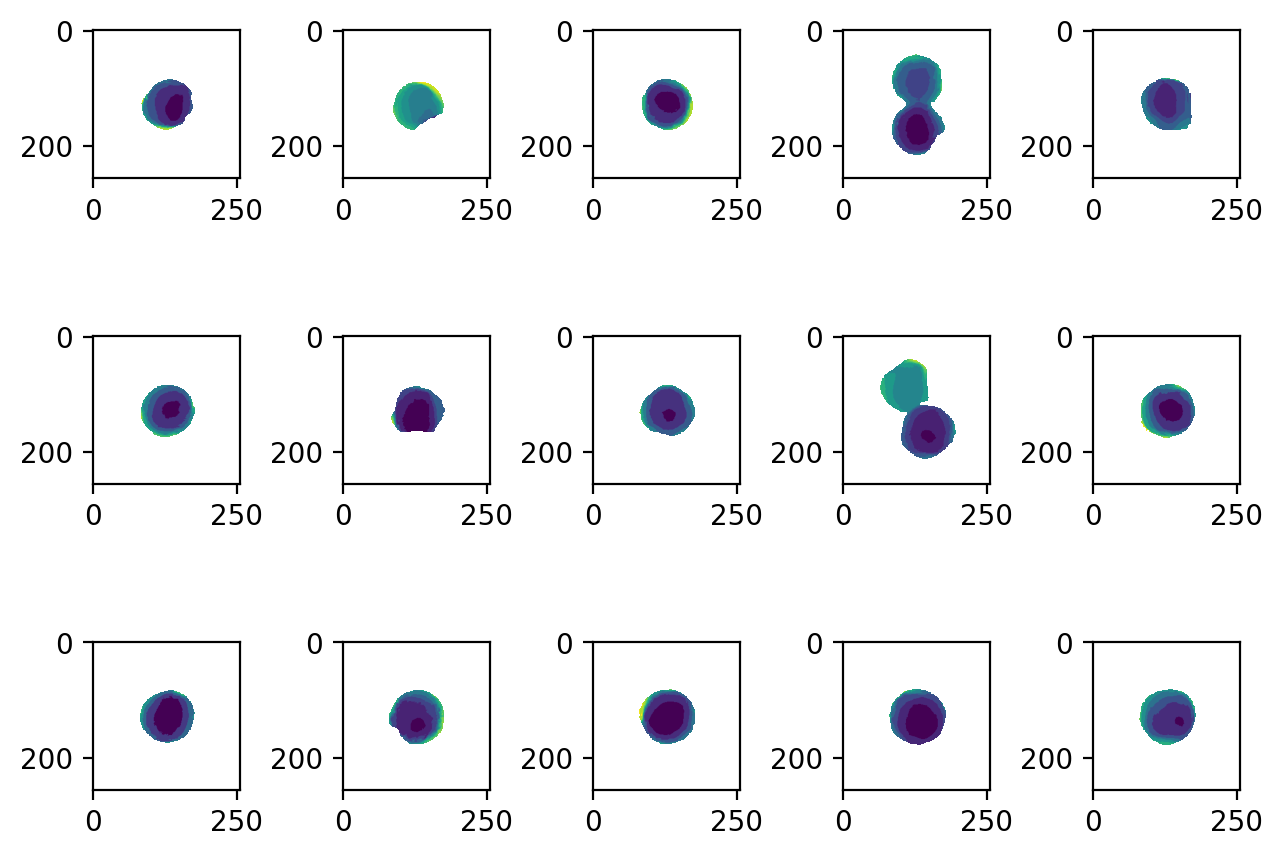

In [13]:
fig,ax=plt.subplots(3,5)
ax=ax.flatten()
for i,m in enumerate(subjects):
    masked_image = np.where(m, imgall[0], np.nan)
    notnan_indices = np.where(~np.isnan(masked_image))
    x = np.mean(notnan_indices[0]).astype(int)
    y = np.mean(notnan_indices[1]).astype(int)
    clip_masked_image = masked_image[x-128:x+128, y-128:y+128,3]
    ax[i].imshow(clip_masked_image, cmap='viridis')  # Choose your preferred colormap
    #ax[i].colorbar()  # Add a colorbar for reference

plt.tight_layout()
plt.show()

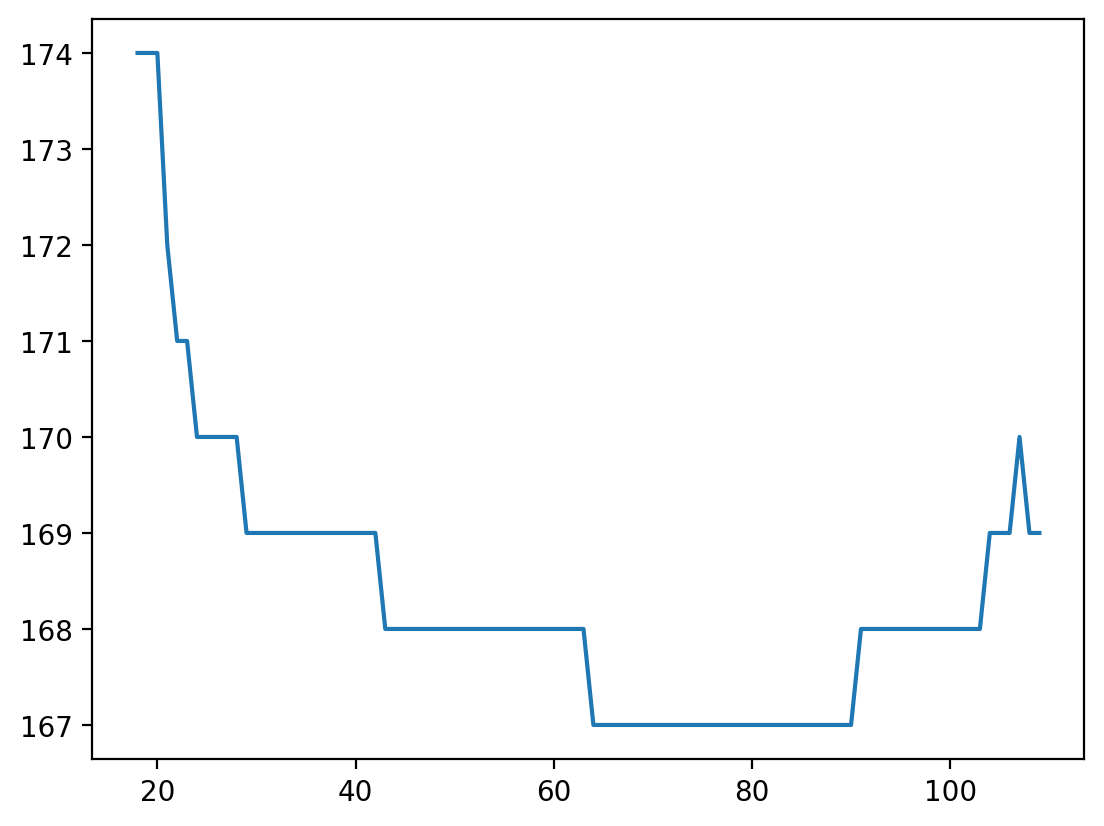

In [15]:
cross_section=clip_masked_image[64]
#cross_section-=np.min(cross_section)

plt.plot(cross_section)

In [71]:
cross_section.shape[0]

93

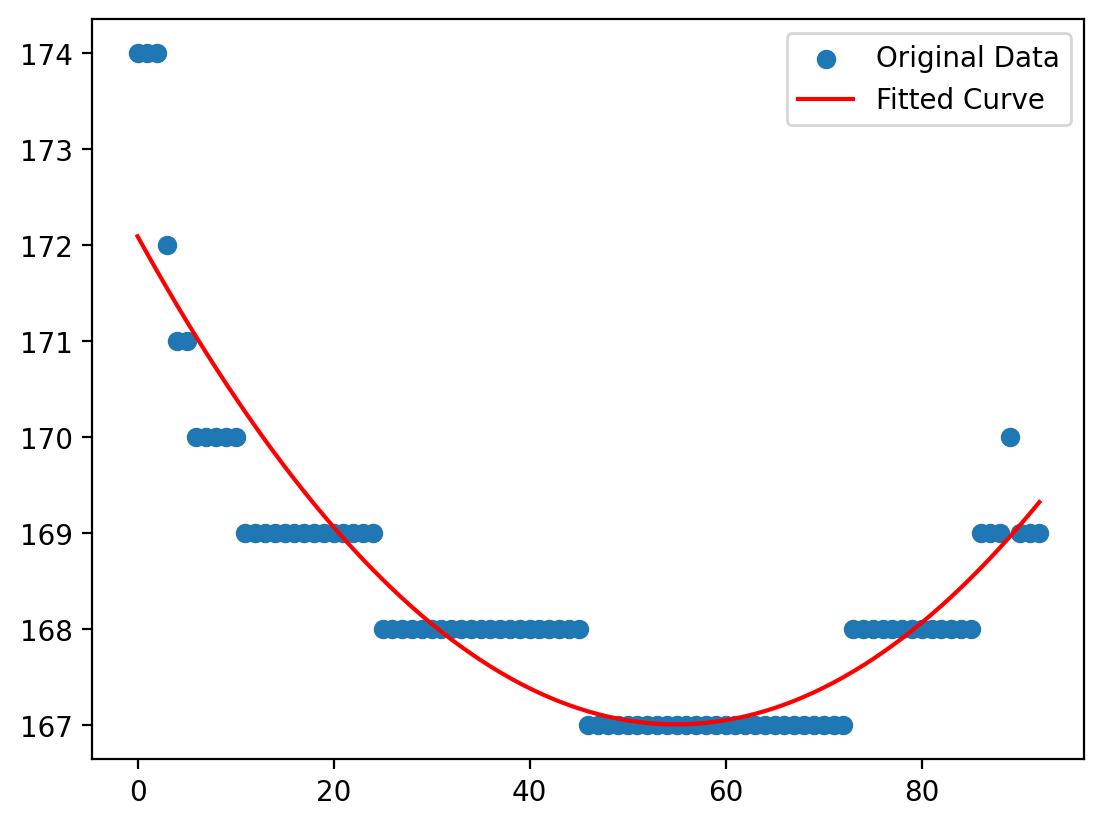

Deviation: 184800422.08962733


In [122]:
degree = 2
cross_section=cross_section[~np.isnan(cross_section)]
x=np.arange(0,cross_section.shape[0],1)
# Fit a polynomial curve to the data
coefficients = np.polyfit(x,cross_section, degree)

# Generate the fitted curve
fitted_curve = np.polyval(coefficients, x)

# Plot the original data and the fitted curve
plt.scatter(x, cross_section, label='Original Data')
plt.plot(x, fitted_curve, label='Fitted Curve', color='red')
plt.legend()
plt.show()

# Calculate deviation
deviation = np.sum((y - fitted_curve) ** 2)
print(f"Deviation: {deviation}")

In [ ]:
#but each pixel should have a different length or surface area

Coef:[ 9.80392157e-03 -1.88235294e-01  1.70776961e+02]
Deviation: 1407.8750249820248
Coef:[ 4.77696376e-16 -9.50889459e-15  1.70000000e+02]
Deviation: 1408.0
Coef:[-7.64738598e-04 -1.69771969e-02  1.70133065e+02]
Deviation: 1408.3548850294446
Coef:[ 3.21750322e-04 -5.28314028e-02  1.70263514e+02]
Deviation: 1408.5278443190787
Coef:[ 1.55204977e-03 -9.76220603e-02  1.70577749e+02]
Deviation: 1408.5366615218325
Coef:[ 1.35801172e-03 -8.32711778e-02  1.70284519e+02]
Deviation: 1408.659139924316
Coef:[ 4.91686036e-05 -3.04213175e-02  1.70242977e+02]
Deviation: 1408.449035527028
Coef:[ 5.42219791e-04 -5.28123470e-02  1.70236489e+02]
Deviation: 1408.6275056967622
Coef:[ 9.66723497e-04 -6.60735245e-02  1.70008005e+02]
Deviation: 1408.830223935037
Coef:[ 9.03512700e-04 -6.54143195e-02  1.70058141e+02]
Deviation: 1408.8214672914376
Coef:[ 8.43146085e-04 -6.72543139e-02  1.70149319e+02]
Deviation: 1408.8475092497843
Coef:[ 1.02813137e-03 -8.14010129e-02  1.70164795e+02]
Deviation: 1409.032328492

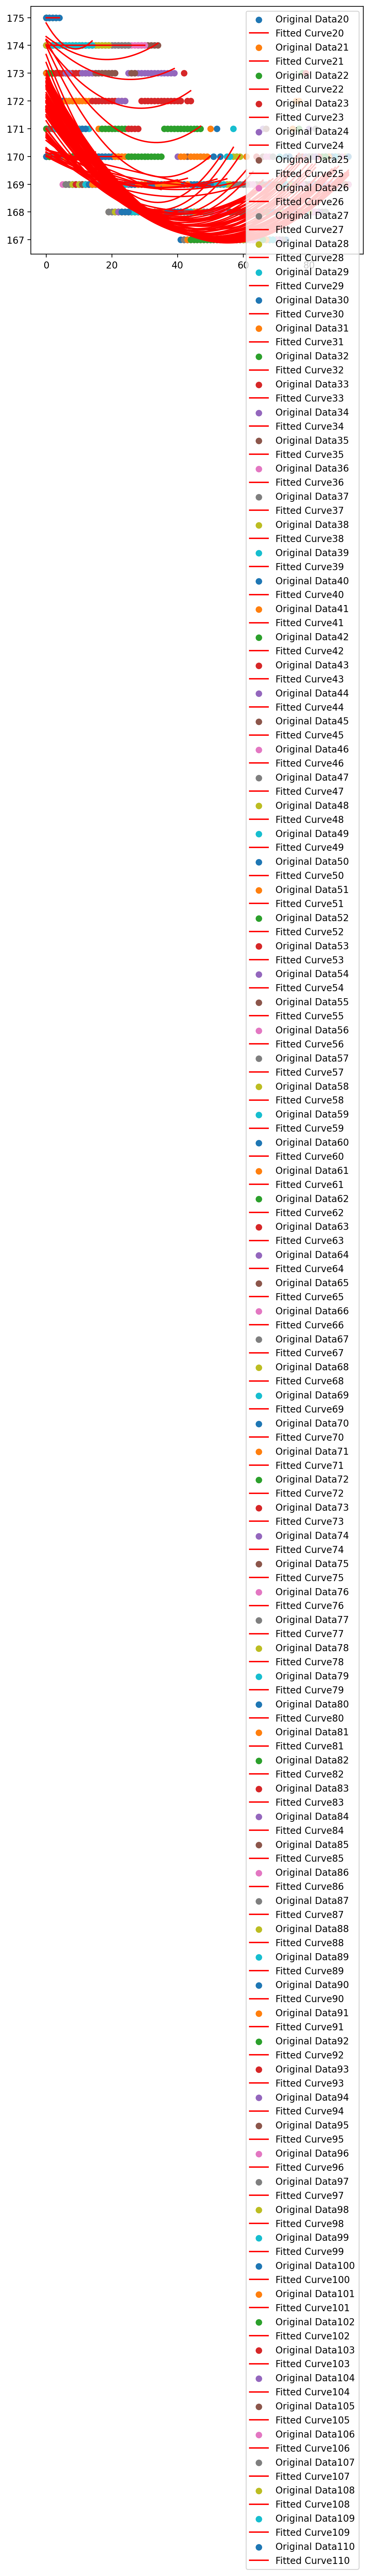

In [123]:
degree = 2
coef=[]
rmse=[]
for i in np.arange(0,128,1):
    cross_section=clip_masked_image[i]
    cross_section=cross_section[~np.isnan(cross_section)]
    if sum(cross_section!=0)>0:
        xr=np.arange(0,cross_section.shape[0],1)
        # Fit a polynomial curve to the data
        coefficients = np.polyfit(xr,cross_section, degree)
        coef.append(coefficients)
        # Generate the fitted curve
        fitted_curve = np.polyval(coefficients, xr)

        # Plot the original data and the fitted curve
        plt.scatter(xr, cross_section, label=f'Original Data{i}')
        plt.plot(xr, fitted_curve, label=f'Fitted Curve{i}', color='red')
        plt.legend()
        #plt.show()

        # Calculate deviation
        deviation = np.sqrt(((y - fitted_curve) ** 2).mean())
        rmse.append(deviation)
        print(f'Coef:{coefficients}')
        print(f"Deviation: {deviation}")

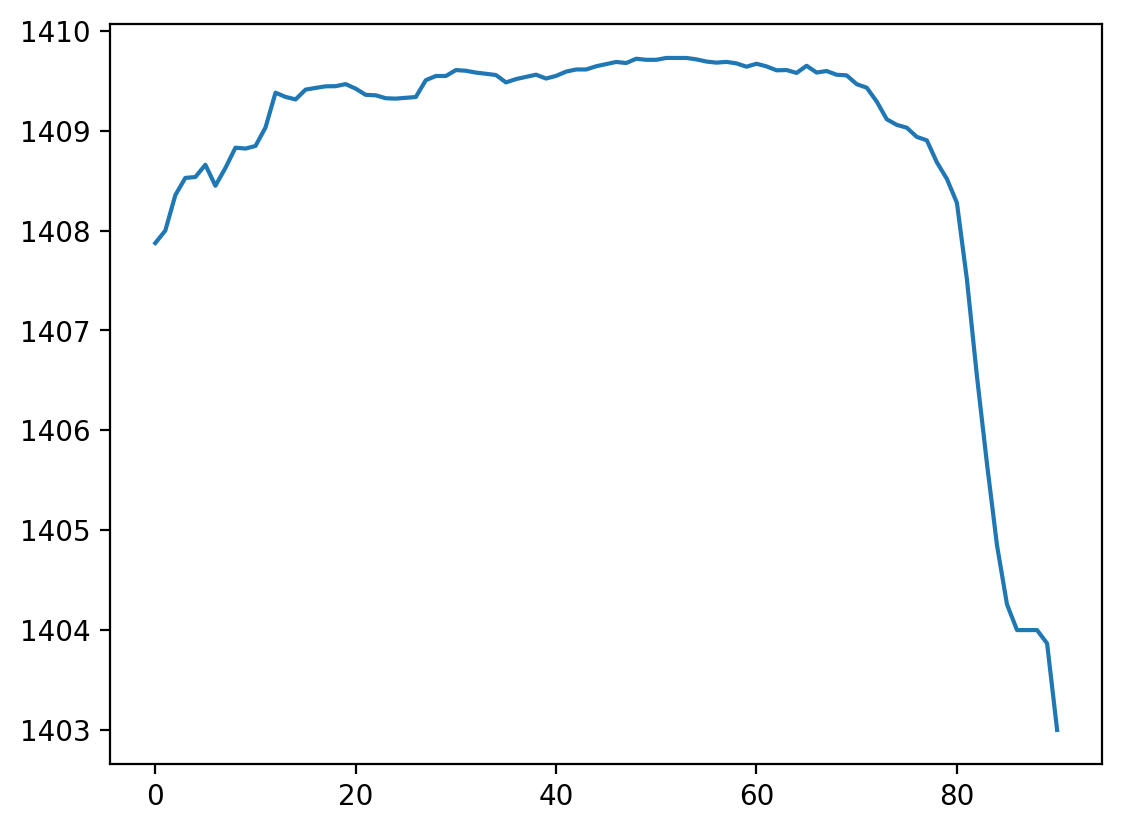

In [124]:
plt.plot(rmse)

In [22]:
def generate_sphere_points(center, radius, num_points=100):
    # Generate points on a sphere
    phi = np.linspace(0, np.pi, num_points)
    theta = np.linspace(0, 2 * np.pi, num_points)
    phi, theta = np.meshgrid(phi, theta)

    x = center[0] + radius * np.sin(phi) * np.cos(theta)
    y = center[1] + radius * np.sin(phi) * np.sin(theta)
    z = center[2] + radius * np.cos(phi)

    return np.column_stack([x.flatten(), y.flatten(), z.flatten()])

def sphere_objective(params, points):
    xc, yc, zc, R = params
    distances = np.sum((points - np.array([xc, yc, zc]))**2, axis=1) - R**2
    return np.sum(distances**2)

def fit_sphere(depth_array):
    # Convert depth array indices to 3D coordinates
    indices = np.argwhere(depth_array)
    points = np.column_stack([indices[:, 1], indices[:, 0], depth_array[depth_array > 0]])

    # Initial guess for parameters (xc, yc, zc, R)
    initial_guess = [0, 0, 0, 1]

    # Perform the fit
    result = minimize(sphere_objective, initial_guess, args=(points,), method='trust-constr')
    xc, yc, zc, R = result.x

    return xc, yc, zc, R


In [23]:
cmi=clip_masked_image.copy()
cmi=np.where(np.isnan(cmi),0,cmi)
xc, yc, zc, R = fit_sphere(cmi)
print("Center:", (xc, yc, zc))
print("Radius:", R)

Center: (70.01838640228188, 62.63281338243229, 341.4356701755082)
Radius: 175.71197230429092


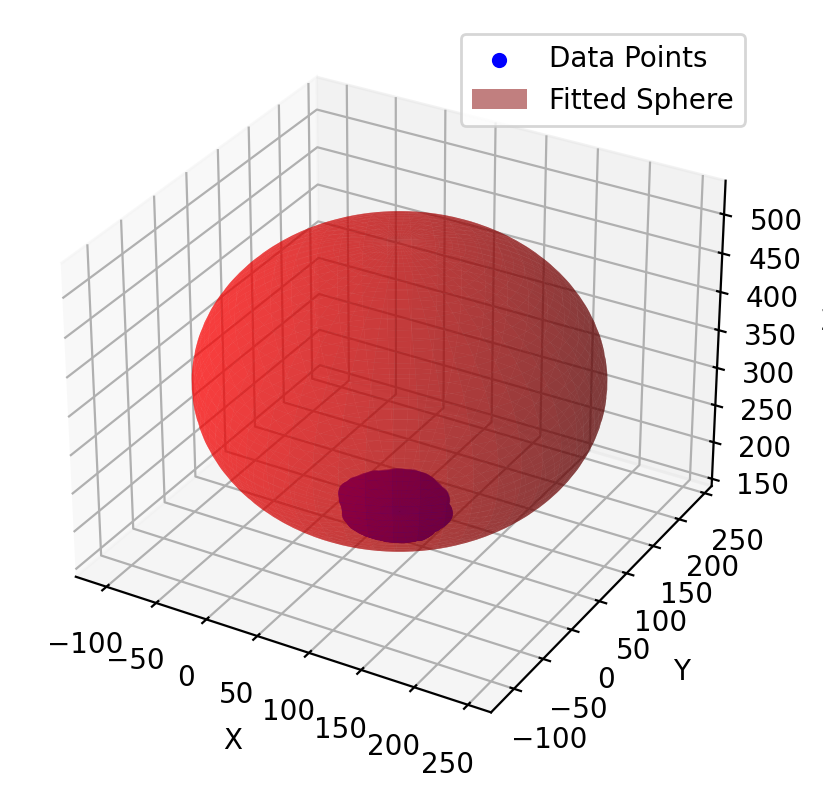

In [26]:
from mpl_toolkits.mplot3d import Axes3D

def generate_sphere_points(center, radius, num_points=100):
    phi = np.linspace(0, np.pi, num_points)
    theta = np.linspace(0, 2 * np.pi, num_points)
    phi, theta = np.meshgrid(phi, theta)

    x = center[0] + radius * np.sin(phi) * np.cos(theta)
    y = center[1] + radius * np.sin(phi) * np.sin(theta)
    z = center[2] + radius * np.cos(phi)

    return x, y, z

def sphere_objective(params, points):
    xc, yc, zc, R = params
    distances = np.sum((points - np.array([xc, yc, zc]))**2, axis=1) - R**2
    return np.sum(distances**2)

def fit_sphere(depth_array):
    indices = np.argwhere(depth_array)
    points = np.column_stack([indices[:, 1], indices[:, 0], depth_array[depth_array > 0]])

    initial_guess = [0, 0, 0, 1]
    result = minimize(sphere_objective, initial_guess, args=(points,), method='trust-constr')
    xc, yc, zc, R = result.x

    return xc, yc, zc, R

xc, yc, zc, R = fit_sphere(cmi)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the original points
indices = np.argwhere(cmi)
ax.scatter(indices[:, 1], indices[:, 0], cmi[cmi > 0], c='b', marker='o', label='Data Points')

# Plot the fitted sphere
sphere_x, sphere_y, sphere_z = generate_sphere_points([xc, yc, zc], R)
ax.plot_surface(sphere_x, sphere_y, sphere_z, color='r', alpha=0.5, label='Fitted Sphere')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

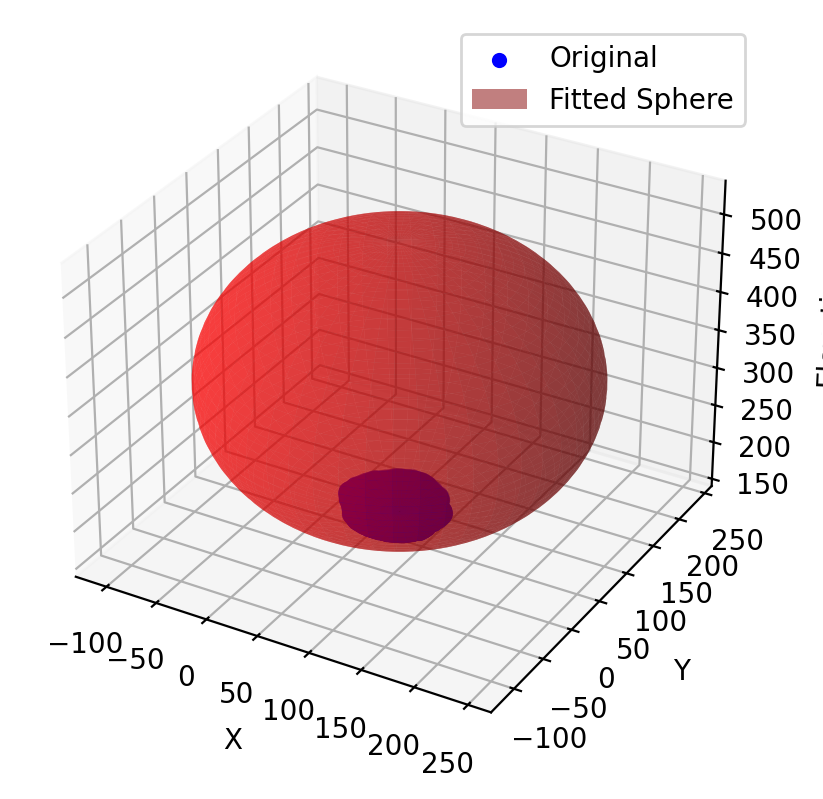

In [27]:
def generate_sphere_points(center, radius, num_points=100):
    phi = np.linspace(0, np.pi, num_points)
    theta = np.linspace(0, 2 * np.pi, num_points)
    phi, theta = np.meshgrid(phi, theta)

    x = center[0] + radius * np.sin(phi) * np.cos(theta)
    y = center[1] + radius * np.sin(phi) * np.sin(theta)
    z = center[2] + radius * np.cos(phi)

    return x, y, z

def sphere_objective(params, points):
    xc, yc, zc, R = params
    distances = np.sum((points - np.array([xc, yc, zc]))**2, axis=1) - R**2
    return np.sum(distances**2)

def fit_and_plot_sphere(dem_array):
    indices = np.argwhere(dem_array)

    if len(indices) == 0:
        print("No data points in the DEM array.")
        return

    points = np.column_stack([indices[:, 1], indices[:, 0], dem_array[dem_array > 0]])

    # Initial guess for parameters (xc, yc, zc, R)
    initial_guess = [0, 0, 0, 1]

    # Perform the fit
    result = minimize(sphere_objective, initial_guess, args=(points,), method='trust-constr')
    xc, yc, zc, R = result.x

    # Generate points on the fitted sphere
    sphere_x, sphere_y, sphere_z = generate_sphere_points([xc, yc, zc], R)

    # Plot the original DEM data
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(indices[:, 1], indices[:, 0], dem_array[dem_array > 0], c='b', marker='o', label='Original')

    # Plot the fitted sphere within the original data bounds
    ax.plot_surface(sphere_x, sphere_y, sphere_z, color='r', alpha=0.5, label='Fitted Sphere')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Elevation')
    ax.legend()
    plt.show()

fit_and_plot_sphere(cmi)